In [1]:
import json, csv, colorsys,re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse.linalg as linalg
import scipy.cluster.hierarchy as hr
import sklearn.metrics as metrics
import sklearn.manifold as manifold
from sklearn import mixture
from sklearn.cluster import KMeans
from sklearn.feature_extraction import text 
from sklearn.utils.extmath import randomized_svd
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize, sent_tokenize
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from collections import defaultdict
%matplotlib inline
from wordcloud import WordCloud, STOPWORDS
word_re = re.compile(r"[\w']+")
# np.set_printoptions(threshold=np.nan)

In [2]:
def word_cloud(text):
    stopwords = set(STOPWORDS)
    newstoplist = ["twitter",'pic','leave','leaving','remain', 'vote','Brexit', 'via', 'will','BBC','html','unlock','flag']
    for i in newstoplist: stopwords.add(i)
    # Generate a word cloud image
    wordcloud = WordCloud(background_color="white", max_words=2000, stopwords=stopwords).generate(text)
    # Display the generated image:
    # the matplotlib way:
    plt.imshow(wordcloud)
    plt.axis("off")

    
    # lower max_font_size
    wordcloud = WordCloud(background_color="white", max_font_size=40, max_words=2000, stopwords=stopwords).generate(text)
    plt.figure()
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

In [3]:
def print_full(x):
    pd.set_option('display.max_rows', len(x))
    print(x)
    pd.reset_option('display.max_rows')

In [4]:
# set the colors we use to plot
def set_color(num):
    ah = 1.0 / num
    l = 0.6
    s = 0.8
    
    colors = [list(colorsys.hls_to_rgb(i * ah, l ,s)) for i in range(num)]
    colors = np.array(colors)
    return colors

In [50]:
# The function we use to draw figure
def draw_scatter(X,title, label = [], num = 0, tag = []):
    fig = plt.figure(1)
    plt.title(title)
    if len(label) == 0:
        plt.scatter(X[:,0], X[:,1], alpha=0.5)
    else:
        inde = defaultdict(list)
        for i, e in enumerate(label):
            inde[e].append(i)
        colors = set_color(num)
        ax = plt.subplot(111)
        for i in range(num):
            plt.scatter(X[inde[i],0], X[inde[i],1], color=colors[i], alpha=0.5)
        box = ax.get_position()
        ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
        plt.legend(tag, scatterpoints=1, prop={'size':6},loc='center left', bbox_to_anchor=(1, 0.5))
    
    plt.xticks(())
    plt.yticks(())

In [6]:
def draw_plot(x, xlabel, ylabel):
    _=plt.figure(1)
    dummy = plt.figure(figsize=(15,5))
    dummy = plt.plot(range(0,len(x)),x, '-o')
    plt.xticks(range(len(x)))
    plt.grid()
    plt.ylabel(ylabel,size=15)
    plt.xlabel(xlabel,size=15)

In [7]:
df_remain = pd.read_csv('remain.csv')
df_leave = pd.read_csv('leave.csv')

/Users/douzhi/Software/anaconda3/envs/cs505/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (1,2,5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [8]:
texts = []
for text in df_remain['text']:
    words = []
    for word in word_re.findall(text):
        if word.isdigit(): continue
        words.append(word)
    texts.append(' '.join(words))
df_remain['text'] = texts 
del texts
texts = []
for text in df_leave['text']:
    words = []
    for word in word_re.findall(text):
        if word.isdigit(): continue
        words.append(word)
    texts.append(' '.join(words))
df_leave['text'] = texts 
del texts

In [9]:
stemmer = PorterStemmer()
stemmed_data = [" ".join(stemmer.stem(word)  for sent in sent_tokenize(message) for word in word_tokenize(sent)) for message in df_remain['text']]
df_remain['text2'] = stemmed_data
del stemmed_data
stemmed_data = [" ".join(stemmer.stem(word)  for sent in sent_tokenize(message) for word in word_tokenize(sent)) for message in df_leave['text']]
df_leave['text2'] = stemmed_data
del stemmed_data

In [10]:
Vectorize1 = TfidfVectorizer(min_df = 0.0005, max_df = 0.6, stop_words = 'english')
dtm_remain = Vectorize1.fit_transform(df_remain['text'].values)
Vectorize2 = TfidfVectorizer(min_df = 0.0005, max_df = 0.6, stop_words = 'english')
dtm_remain_stem = Vectorize2.fit_transform(df_remain['text2'].values)
Vectorize3 = TfidfVectorizer(min_df = 0.0005, max_df = 0.6, stop_words = 'english')
dtm_leave = Vectorize3.fit_transform(df_leave['text'].values)
Vectorize4 = TfidfVectorizer(min_df = 0.0005, max_df = 0.6, stop_words = 'english')
dtm_leave_stem = Vectorize4.fit_transform(df_leave['text2'].values)

In [11]:
dtm_dense_remain = dtm_remain.todense()
centered_dtm_remain = dtm_dense_remain - np.mean(dtm_dense_remain, axis = 0)
del dtm_dense_remain, dtm_remain

In [12]:
dtm_dense_remain_stem = dtm_remain_stem.todense()
centered_dtm_remain_stem = dtm_dense_remain_stem - np.mean(dtm_dense_remain_stem, axis = 0)
del dtm_dense_remain_stem, dtm_remain_stem

In [13]:
dtm_dense_leave = dtm_leave.todense()
centered_dtm_leave = dtm_dense_leave - np.mean(dtm_dense_leave, axis = 0)
del dtm_dense_leave, dtm_leave

In [14]:
dtm_dense_leave_stem = dtm_leave_stem.todense()
centered_dtm_leave_stem = dtm_dense_leave_stem - np.mean(dtm_dense_leave_stem, axis = 0)
del dtm_dense_leave_stem, dtm_leave_stem

In [15]:
U1, S1, VT1 = randomized_svd(centered_dtm_remain, n_components=40, n_iter=10)
del centered_dtm_remain

In [16]:
U2, S2, VT2 = randomized_svd(centered_dtm_remain_stem, n_components=40, n_iter=10)
del centered_dtm_remain_stem

In [17]:
U3, S3, VT3 = randomized_svd(centered_dtm_leave, n_components=40, n_iter=10)
del centered_dtm_leave

In [18]:
U4, S4, VT4 = randomized_svd(centered_dtm_leave_stem, n_components=40, n_iter=10)
del centered_dtm_leave_stem

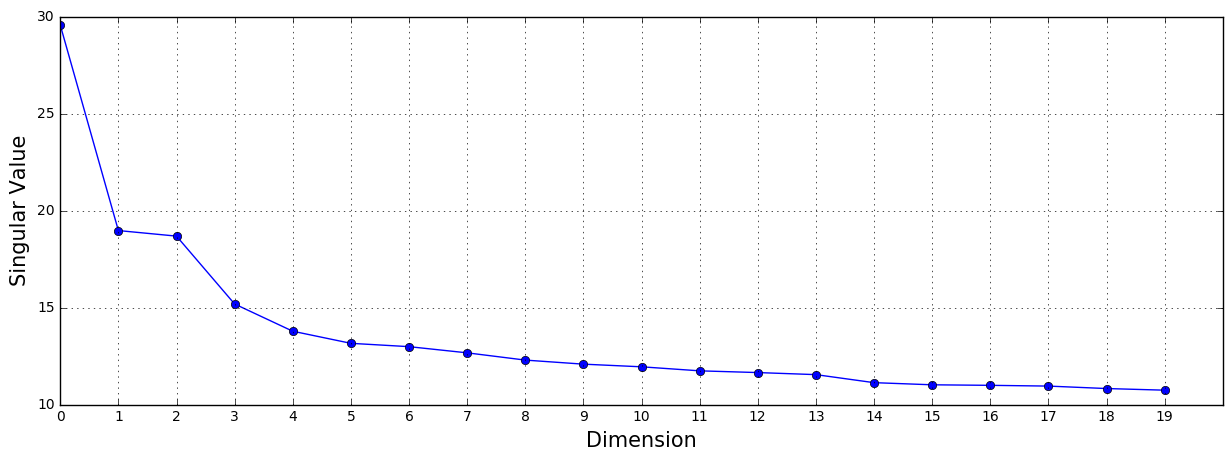

In [46]:
draw_plot(S1[:20], xlabel='Dimension', ylabel='Singular Value')

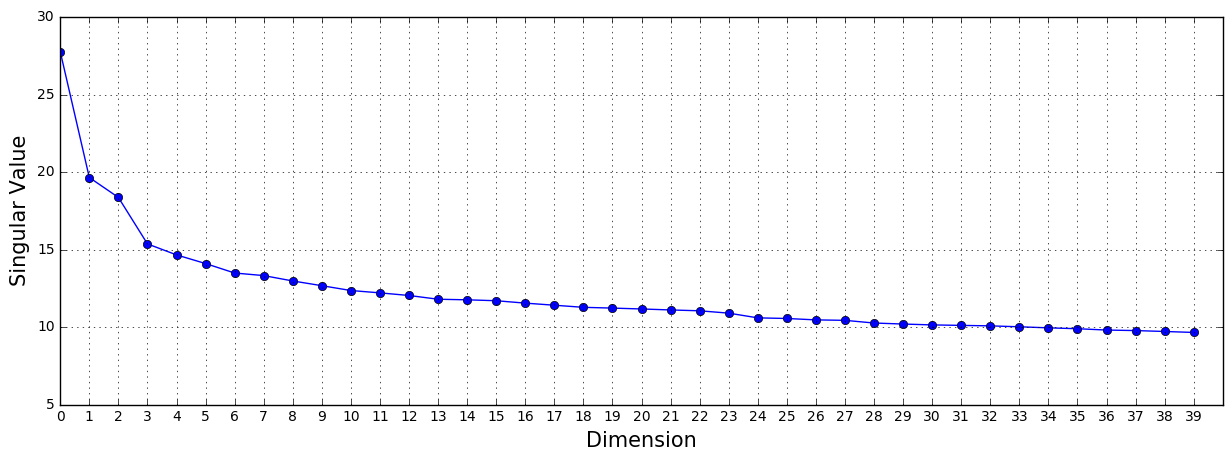

In [20]:
draw_plot(S2, xlabel='Dimension', ylabel='Singular Value')

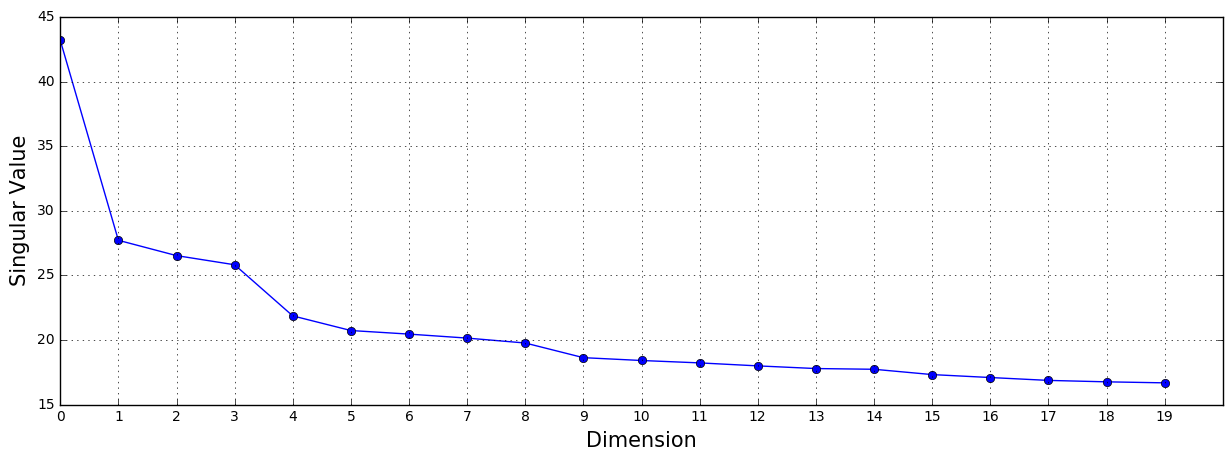

In [47]:
draw_plot(S3[:20], xlabel='Dimension', ylabel='Singular Value')

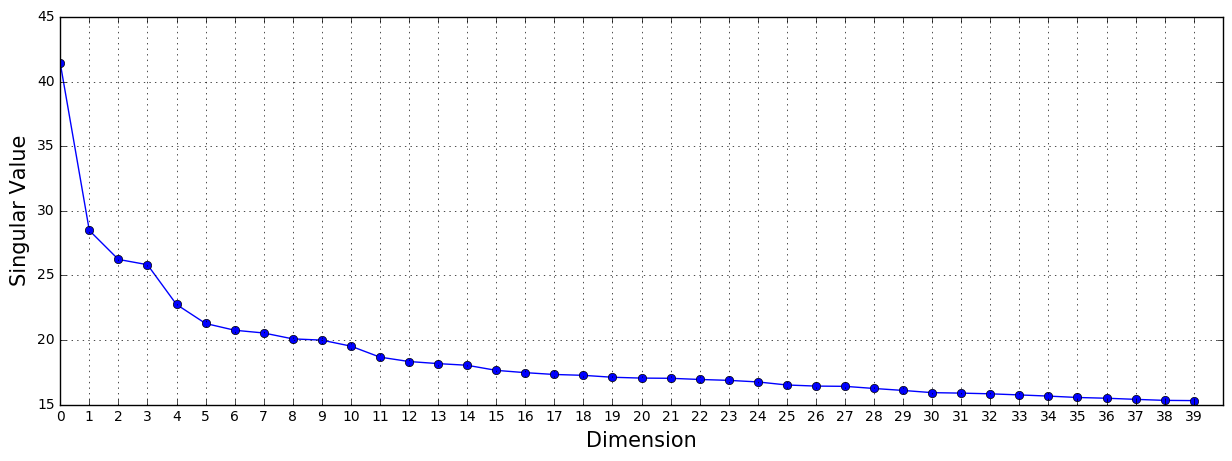

In [22]:
draw_plot(S4, xlabel='Dimension', ylabel='Singular Value')

In [23]:
terms1 = np.array(Vectorize1.get_feature_names())
tops1 = []
for i in range(8):
    top1 = VT1[i].argsort()[::-1]
    topterms1 = [terms1[top1[f]] for f in range(50)]
    print(i, topterms1)
    tops1.append(set(topterms1))

0 ['twitter', 'pic', 'vote', 'enjoy', 'want', 'flag', 'profile', 'unlocked', 'tweet', 'today', 'shit', 'im', '100s', 'ets', 'cityfalcon', 'day', 'stay', 'coming', 'goodbye', 'stories', 'lets', 'dont', 'trust', 'needs', 'dailysquib', 'best', 'days', 'breitbart', 'message', 'poster', 'choice', 'failed', 'rt', 'save', 'taxation', 'wont', 'picture', 'played', 'time', 'june', 'future', 'funding', 'life', 'europewatch', 'late', 'summary', 'true', 'tomorrow', 'cartoon', 'comparing']
1 ['eu', 'referendum', 'uk', 'leave', 'bbc', 'twitter', 'cs', 'britain', 'pic', 'trade', 'leaving', 'membership', 'html', 'safer', 'better', 'law', 'outside', 'deal', 'says', 'stay', 'dailysquib', 'member', 'remain', 'turkey', 'poll', 'debate', 'warns', 'army', 'security', 'join', 'pro', 'exit', 'leaves', 'rules', 'st', 'mean', 'does', 'free', 'remaining', 'funding', 'live', 'report', 'cost', 'votes', 'redundant', 'ahead', 'staying', 'money', 'benefits', 'democratic']
2 ['vote', 'eu', 'unlocked', 'profile', 'flag'

In [24]:
terms2 = np.array(Vectorize2.get_feature_names())
tops2 = []
for i in range(8):
    top2 = VT2[i].argsort()[::-1]
    topterms2 = [terms2[top2[f]] for f in range(50)]
    print(i, topterms2)
    tops2.append(set(topterms2))

0 ['pic', 'twitter', 'vote', 'thi', 'enjoy', 'profil', 'flag', 'unlock', 'want', 'tweet', 'day', 'today', 'shit', 'im', '100', 'cityfalcon', 'et', 'let', 'dont', 'goodby', 'poster', 'trust', 'stori', 'rt', 'dailysquib', 'stay', 'choic', 'futur', 'messag', 'best', 'breitbart', 'come', 'spot', 'taxat', 'tomorrow', 'wont', 'pictur', 'know', 'failur', 'ote', 'need', 'europewatch', 'cartoon', 'thank', 'event', 'question', 'guid', 'imag', 'alien', 'fail']
1 ['vote', 'unlock', 'profil', 'flag', 'leav', 'remain', 'poll', 'regist', 'june', 'peopl', 'referendum', 'pleas', 'whi', 'reason', 'futur', 'britain', 'today', '23rd', 'stay', 'way', 'cast', 'count', 'postal', 'did', 'sure', 'll', 'befor', 'tomorrow', 'result', 'bother', 'te', 'goodby', 'young', 'rt', 'thursday', 'lead', 'decid', 'gov', 'hour', 'becaus', 'retweet', 'elect', 'everyon', 'intent', 'regret', 'chanc', 'anyon', 'import', 'brit', 'forget']
2 ['eu', 'uk', 'referendum', 'leav', 'britain', 'bbc', 'twitter', 'cs', 'remain', 'pic', 't

In [25]:
terms3 = np.array(Vectorize3.get_feature_names())
tops3 = []
for i in range(8):
    top3 = VT3[i].argsort()[::-1]
    topterms3 = [terms3[top3[f]] for f in range(50)]
    print(i, topterms3)
    tops3.append(set(topterms3))

0 ['twitter', 'pic', 'page', 'fb', 'brexit', 'time', 'vote', 'blog', 'facebook', 'britain', 'june', 'rt', '23rd', 'tweet', 'battle', 'flag', 'goodbye', 'soldier', 'today', 'im', 'needs', 'leave', 'billion', 'shit', 'let', 'betrayal', 'enjoy', 'law', 'unlocked', 'profile', 'cat', 'want', 'children', 'winston', 'control', 'dont', 'nation', 'old', 'remember', 'ukleave_eu', 'think', 'churchill', 'lets', 'bag', 'lied', 'juncker', 'campaigning', 'waste', 'retweet', 'govern']
1 ['eu', 'vote', 'leave', 'referendum', 'uk', 'britain', 'remain', 'html', 'stay', 'pic', 'dailysquib', 'twitter', 'trade', 'want', 'reasons', 'cs', 'bbc', 'turkey', 'voting', 'youtube', 'support', 'army', 'funded', 'europe', 'add', 'help', 'unlocked', 'outside', 'poll', 'profile', 'million', 'leaving', 'claims', 'leaflet', 'june', 'flag', 'lse', 'taxpayer', 'uncovered', 'gov', 'join', 'reasonstovoteleave', 'nhs', 'pro', 'law', 'risks', 'workers', 'membership', 'staying', 'safer']
2 ['vote', 'leave', 'remain', 'brexit', 

In [26]:
terms4 = np.array(Vectorize4.get_feature_names())
tops4 = []
for i in range(8):
    top4 = VT4[i].argsort()[::-1]
    topterms4 = [terms4[top4[f]] for f in range(50)]
    print(i, topterms4)
    tops4.append(set(topterms4))

0 ['pic', 'twitter', 'page', 'fb', 'brexit', 'time', 'vote', 'blog', 'thi', 'facebook', 'britain', 'june', '23rd', 'rt', 'let', 'tweet', 'battl', 'flag', 'goodby', 'leav', 'im', 'today', 'soldier', 'day', 'shit', 'profil', 'unlock', 'enjoy', 'cat', 'juncker', 'children', 'dont', 'billion', 'rememb', 'winston', 'churchil', 'ukleave_eu', 'old', 'control', 'bag', 'commun', 'betray', 'fish', 'imagin', 'interf', 'mug', 'readi', 'switzerland', 'retweet', 'era']
1 ['vote', 'leav', 'eu', 'whi', 'remain', 'referendum', 'britain', 'june', 'reason', 'stay', 'unlock', 'uk', 'profil', '23rd', 'flag', 'poll', 'want', 'html', 'join', 'pleas', 'save', 'dailysquib', 'nh', 'democraci', 'support', 'healthcar', 'reasonstovoteleav', 'europ', 'add', 'regist', 'worker', 'help', 'futur', 'postal', 'll', 'risk', 'count', 'union', 'pic', 'trade', 'goodby', 'cs', 'undecid', 'thursday', 'urg', 'te', 'turkey', 'time', 'say', 'demis']
2 ['eu', 'brexit', 'uk', 'britain', 'page', 'fb', 'leav', 'referendum', 'html', '

## Top Five Tags for Remain

0. Economy/Trade
1. Jobs/Market/Risk
2. Law/Govern
3. Security
4. Nation/Leader

## Top Five Tags for Leave

1. Freedom/Sovereignty/Great
2. Tax
3. Economy/Trade
4. Migrants
5. Lie/Brussels

## Kmeans

In [76]:
Xk1 = U1 @ np.diag(S1)

In [77]:
error = np.zeros(31)
for k in range(1,31):
    vectorsk1 = Xk1[:,:k]
    kmeans = KMeans(n_clusters=8, init='k-means++', max_iter=100, n_init=10, random_state=0)
    kmeans.fit_predict(vectorsk1)
    error[k] = kmeans.inertia_

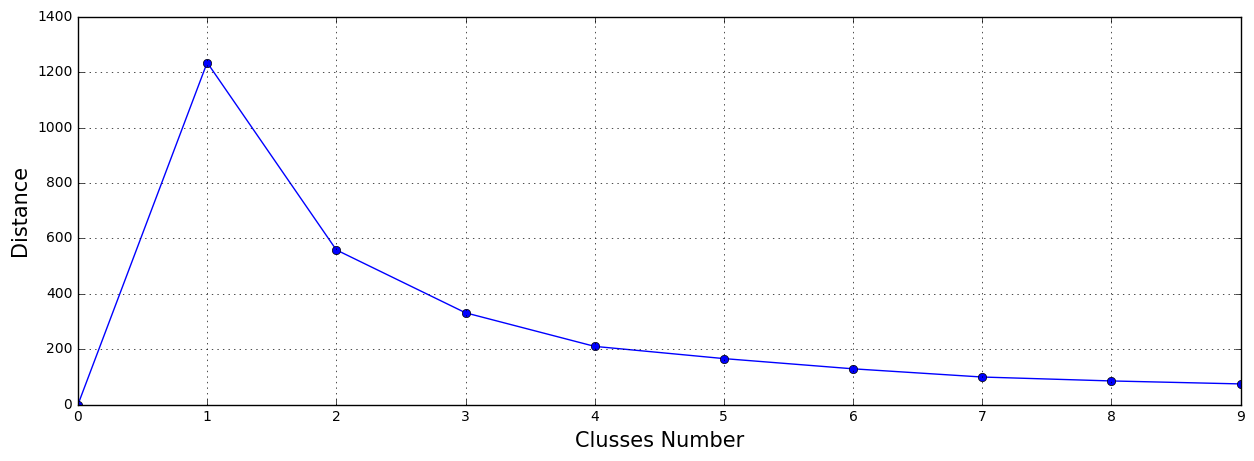

In [83]:
draw_plot(error[0:10], xlabel='Clusses Number', ylabel='Distance')

In [81]:
error1 = np.zeros(31)
for k in range(1,31):
    vectorsk1 = Xk1[:,:2]
    kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=100, n_init=10, random_state=0)
    kmeans.fit_predict(vectorsk1)
    error1[k] = kmeans.inertia_

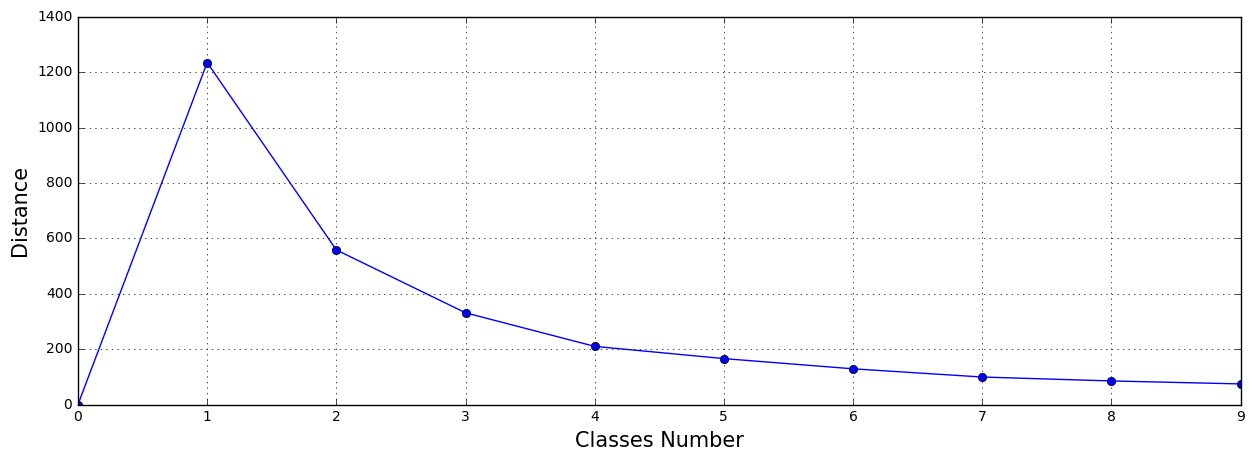

In [84]:
draw_plot(error1[:10], xlabel='Classes Number', ylabel='Distance')

In [32]:
Xk3 = U3 @ np.diag(S3)

In [33]:
error3 = np.zeros(31)
for k in range(1,31):
    vectorsk3 = Xk3[:,:2]
    kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=100, n_init=10, random_state=0)
    kmeans.fit_predict(vectorsk3)
    error3[k] = kmeans.inertia_

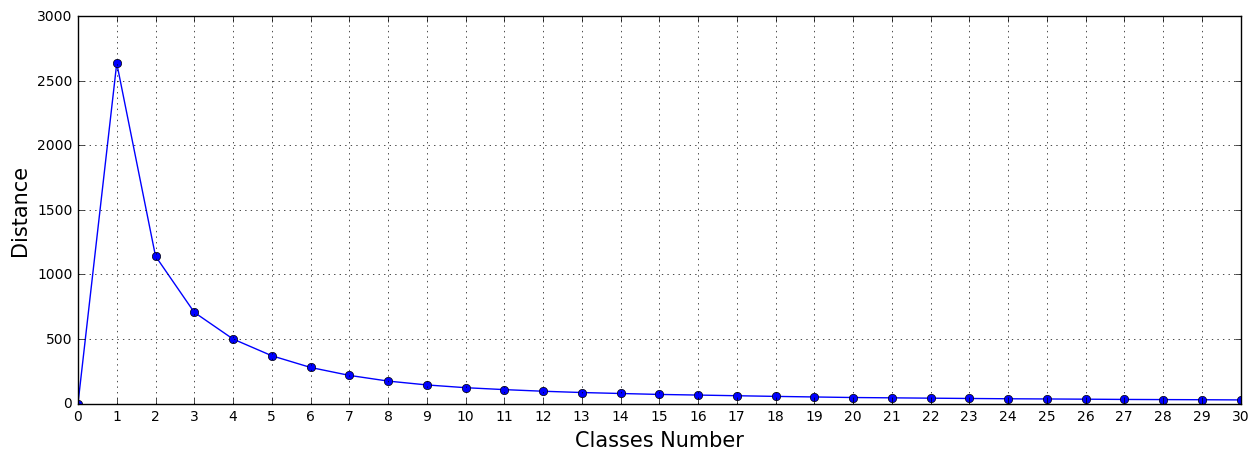

In [34]:
draw_plot(error3, xlabel='Classes Number', ylabel='Distance')

In [35]:
Xk1 = U1 @ np.diag(S1)

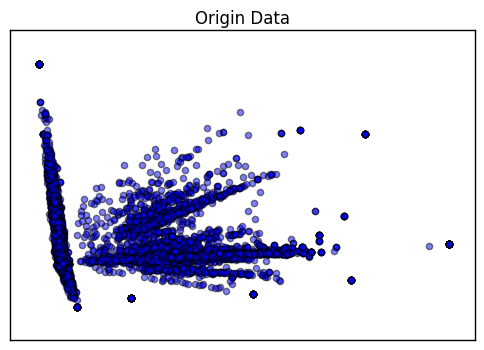

In [36]:
draw_scatter(Xk1[:,:2],"Origin Data")

In [72]:
Xk1 = U1 @ np.diag(S1)
N = 4
vectorsk_remain = Xk1[:,:2]
kmeans_remain = KMeans(n_clusters=N, init='k-means++', max_iter=100, n_init=10, random_state=0)
kmeans_remain.fit_predict(vectorsk_remain)
labelsk_remain = kmeans_remain.labels_

Xk2 = U2 @ np.diag(S2)
vectorsk_remain_stem = Xk2[:,:2]
kmeans_remain_stem = KMeans(n_clusters=N, init='k-means++', max_iter=100, n_init=10, random_state=0)
kmeans_remain_stem.fit_predict(vectorsk_remain_stem)
labelsk_remain_stem = kmeans_remain_stem.labels_

df_remain['kmean_remain'] = kmeans_remain.labels_
df_remain['kmean_remain_stem'] = kmeans_remain_stem.labels_

ktag_remain=[]
for i in range(N):
    df_remain.index = df_remain['kmean_remain']
    cdis = euclidean_distances(vectorsk_remain[df_remain.ix[i]['Unnamed: 0'].values,:2], [kmeans_remain.cluster_centers_[i]]).T.argsort()
    top1 = cdis[0][:10]
    
    df_remain.index = df_remain['kmean_remain_stem']
    cdis_stem = euclidean_distances(vectorsk_remain_stem[df_remain.ix[i]['Unnamed: 0'].values,:2], [kmeans_remain_stem.cluster_centers_[i]]).T.argsort()
    top1_stem = cdis_stem[0][:10]
    
    indeces = list(set(top1) | set(top1_stem))
    ktag_remain.append(df_remain.iloc[indeces]['text'].values)

In [67]:
ktexts_remain = ''
for i in ktag_remain:
    temp = ' '.join(i)
    ktexts_remain += temp
    

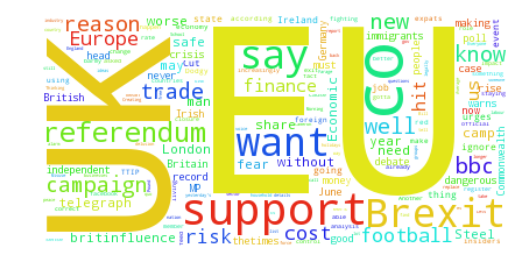

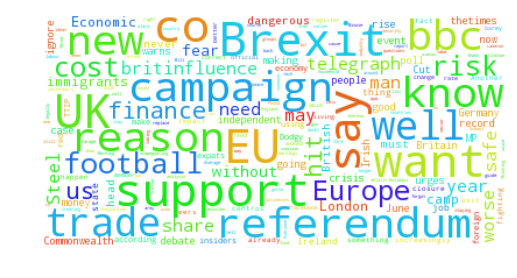

In [68]:
word_cloud(ktexts_remain)

In [73]:
ktag_remain = ['Economic', 'Financial','Banking', 'Indenpendent']

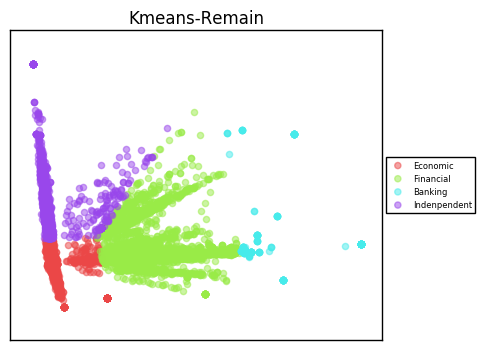

In [74]:
draw_scatter(X=Xk1, num=N, label=kmeans_remain.labels_, title="Kmeans-Remain", tag=ktag_remain)

In [ ]:
draw_scatter(X=Xk2, num=8, label=kmeans_remain_stem.labels_)

TypeError: draw_scatter() missing 1 required positional argument: 'title'

In [85]:
Xk3 = U3 @ np.diag(S3)
lN = 5
vectorsk_leave = Xk3[:,:2]
kmeans_leave = KMeans(n_clusters=lN, init='k-means++', max_iter=100, n_init=10, random_state=0)
kmeans_leave.fit_predict(vectorsk_leave)
labelsk_leave = kmeans_leave.labels_

Xk4 = U4 @ np.diag(S4)
vectorsk_leave_stem = Xk4[:,:2]
kmeans_leave_stem = KMeans(n_clusters=lN, init='k-means++', max_iter=100, n_init=10, random_state=0)
kmeans_leave_stem.fit_predict(vectorsk_leave_stem)
labelsk_leave_stem = kmeans_leave_stem.labels_

df_leave['kmean_leave'] = kmeans_leave.labels_
df_leave['kmean_leave_stem'] = kmeans_leave_stem.labels_

ktag_leave=[]
for i in range(lN):
    df_leave.index = df_leave['kmean_leave']
    cdis = euclidean_distances(vectorsk_leave[df_leave.ix[i]['Unnamed: 0'].values,:2], [kmeans_leave.cluster_centers_[i]]).T.argsort()
    top1 = cdis[0][:10]
    
    df_leave.index = df_leave['kmean_leave_stem']
    cdis_stem = euclidean_distances(vectorsk_leave_stem[df_leave.ix[i]['Unnamed: 0'].values,:2], [kmeans_leave_stem.cluster_centers_[i]]).T.argsort()
    top1_stem = cdis_stem[0][:10]
    
    indeces = list(set(top1) | set(top1_stem))
    ktag_leave.append(df_leave.iloc[indeces]['text'].values)

In [86]:
klabel_leave=['Refugee', 'Expense', 'Trade', 'Employment', 'Political Change']

In [132]:
ktexts_leave=''
for i in ktag_leave:
    temp = ' '.join(i)
    ktexts_leave += temp

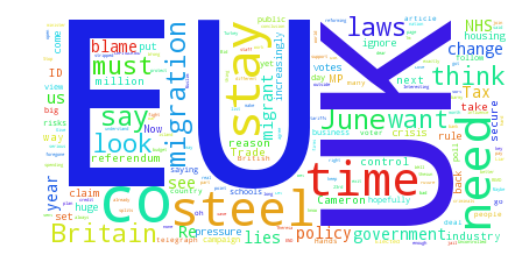

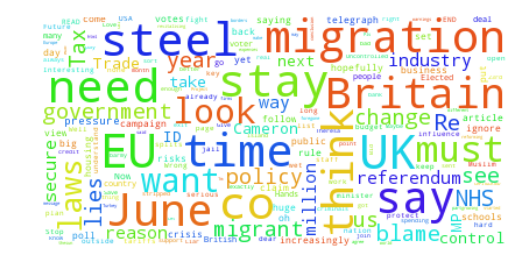

In [133]:
word_cloud(ktexts_leave)

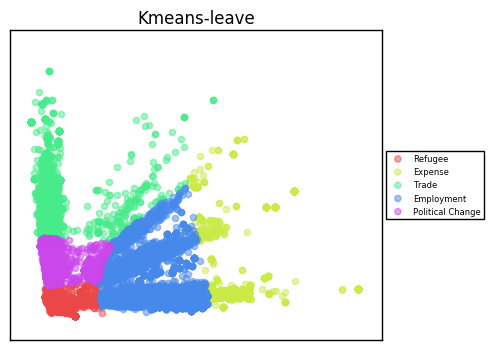

In [87]:
draw_scatter(X=Xk3, num=lN, label=kmeans_leave.labels_,title='Kmeans-leave', tag=klabel_leave)

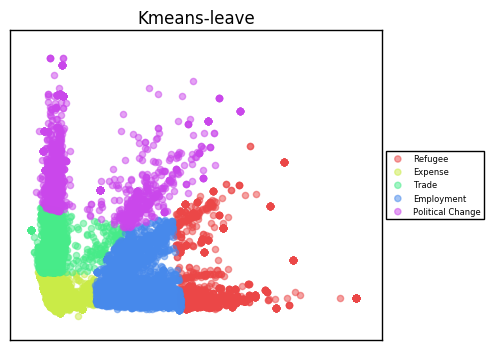

In [88]:
draw_scatter(X=Xk4, num=lN, label=kmeans_leave_stem.labels_,title='Kmeans-leave', tag=klabel_leave)

## GMM

In [99]:
def GMMchoseK(Xk):
    # to estimate GMM model
    N = 10
    error = np.zeros(N + 20)
    for k in range(1, N):
        feature = Xk[:,:2]
        gmm = mixture.GaussianMixture(n_components=k, covariance_type='full')
        gmm.fit(feature)
        gmm.predict(feature)
        error[k] = gmm.score(feature)
    # number of classes and likelyhood
    for i in range(20):
        error[N + i] = error[N - 1]
    draw_plot(error, xlabel='Classes Number', ylabel='Likelyhood') 

In [91]:
def GMM(X,df, label):
    feature = X[:,:2]
    # Do GMM classification and plot
    gnum = 4
    gmm = mixture.GaussianMixture(n_components=gnum, covariance_type='full')
    gmm.fit(feature)
    gclusters = gmm.predict(feature)
    draw_scatter(feature, label=gclusters, num=gnum,title='GMM', tag=label)

    # get the probability of each point in each class and get the largest probability
    pro = gmm.predict_proba(feature)
    pros = [i.max() for i in pro]
    # build a data frame contain the cluster this point belonging to, and its probability, and its index in the origin table
    df_gmm = pd.DataFrame(data=gclusters, columns = ['cluster'])
    df_gmm['Pro'] = pros
    df_gmm['index'] = np.array(range(len(feature)))
    # make cluster as the index of data frame
    df_gmm.index = df_gmm['cluster']
    # print the size of each cluster
    print('Categories of {} cluster by GMM'.format(gnum))
    for k in range(gnum):
        print('Cluster {} size: {}'.format(k + 1, len(df_gmm.ix[k])))

    # for each cluster sort the its point in the probability, take the point has most prosibble belonging this 
    # cluster, its label as the label for this cluster
    gtag = []
    for k in range(gnum):
        first10 = df_gmm.ix[k].sort_values(['Pro'], ascending = False)['index'][0:10].values
        gtag.append(df.iloc[first10]['text'].values)
    return gtag

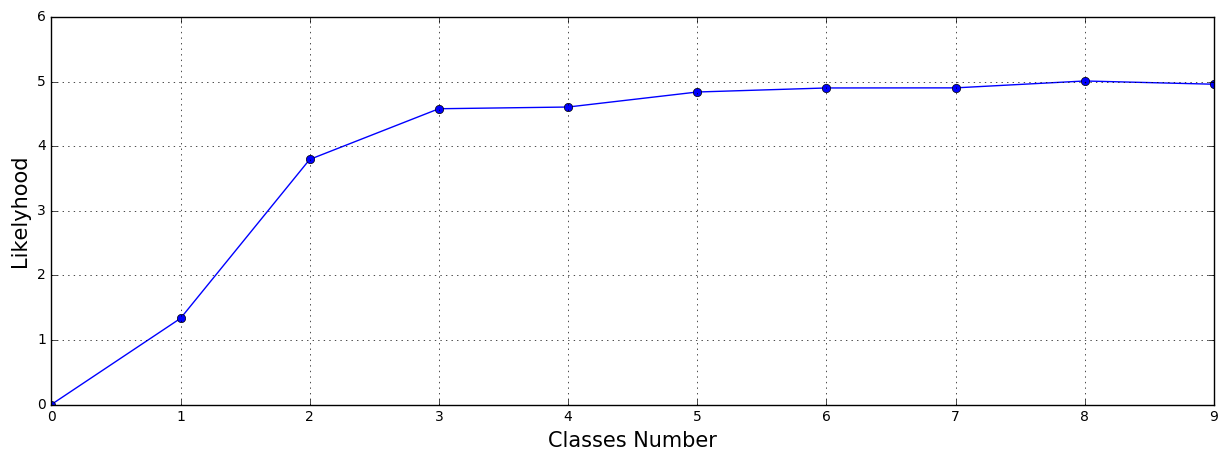

In [93]:
Xk1 = U1 @ np.diag(S1)
GMMchoseK(Xk1)

Categories of 4 cluster by GMM
Cluster 1 size: 11810
Cluster 2 size: 4728
Cluster 3 size: 17196
Cluster 4 size: 2671


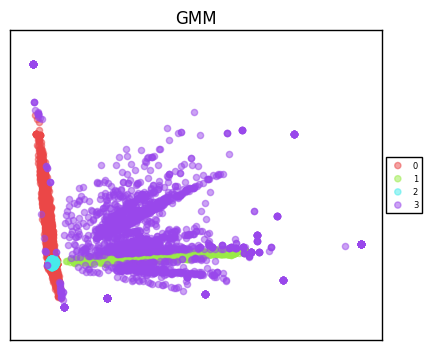

In [289]:
gtag1 = GMM(Xk1, df_remain)

In [94]:
glabel_r=['International Politics','David  Cameron','Europe Family','Reform EU']

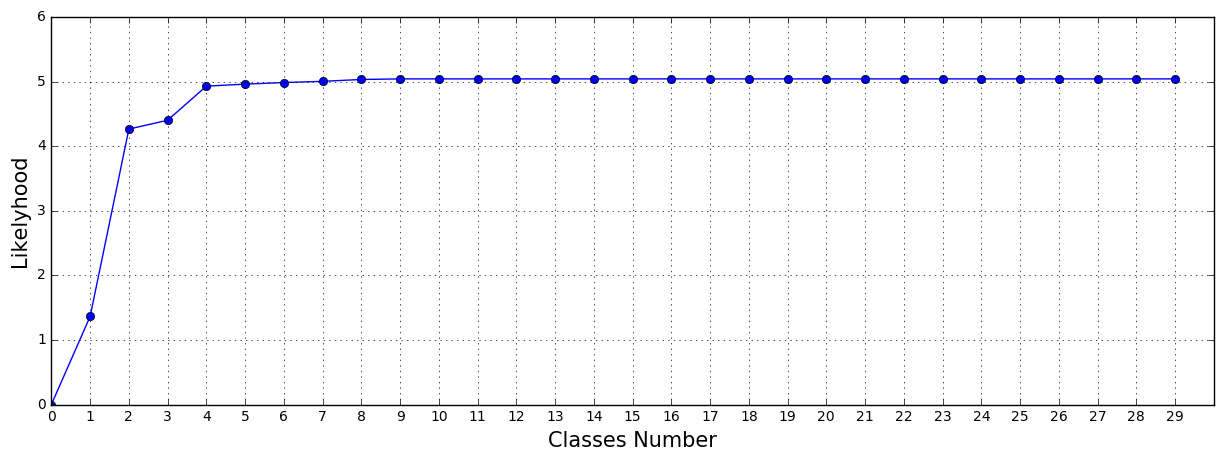

In [100]:
Xk2 = U2 @ np.diag(S2)
GMMchoseK(Xk2)

Categories of 4 cluster by GMM
Cluster 1 size: 5030
Cluster 2 size: 23886
Cluster 3 size: 6033
Cluster 4 size: 1456


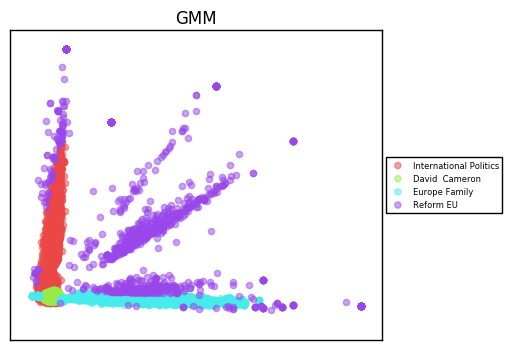

In [96]:
gtag2=GMM(Xk2,df_remain,glabel_r)

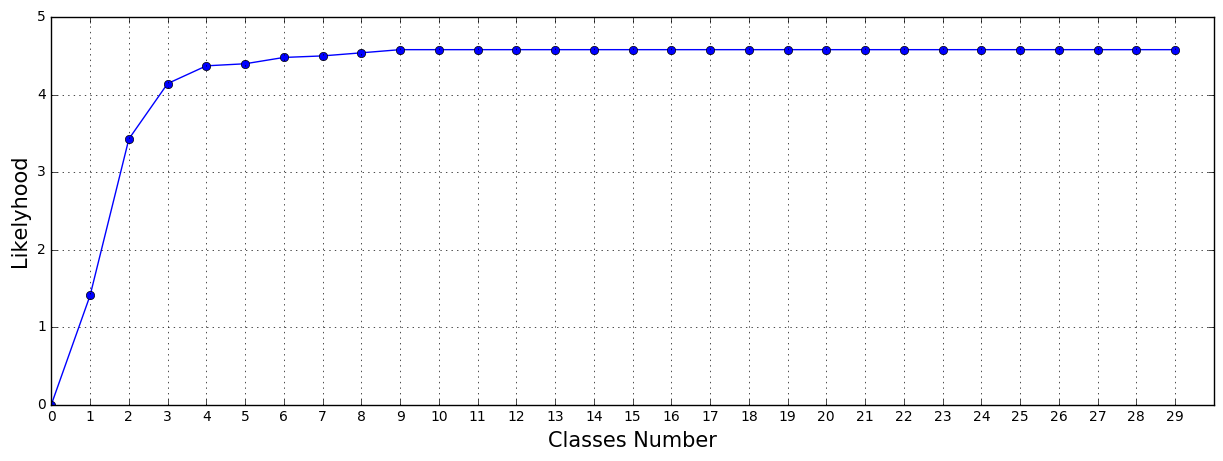

In [101]:
Xk3 = U3 @ np.diag(S3)
GMMchoseK(Xk3)

Categories of 4 cluster by GMM
Cluster 1 size: 6599
Cluster 2 size: 38054
Cluster 3 size: 11187
Cluster 4 size: 27774


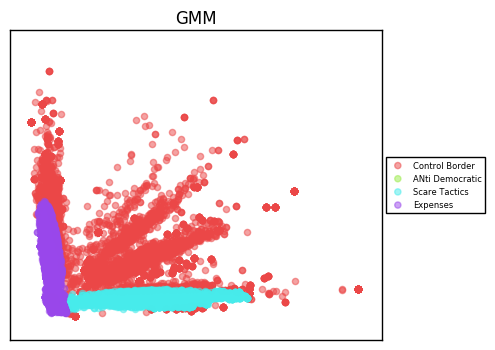

In [106]:
gtag3=GMM(Xk3,df_leave,glabel_l)

In [102]:
glabel_l = ['Control Border', 'ANti Democratic','Scare Tactics','Expenses']

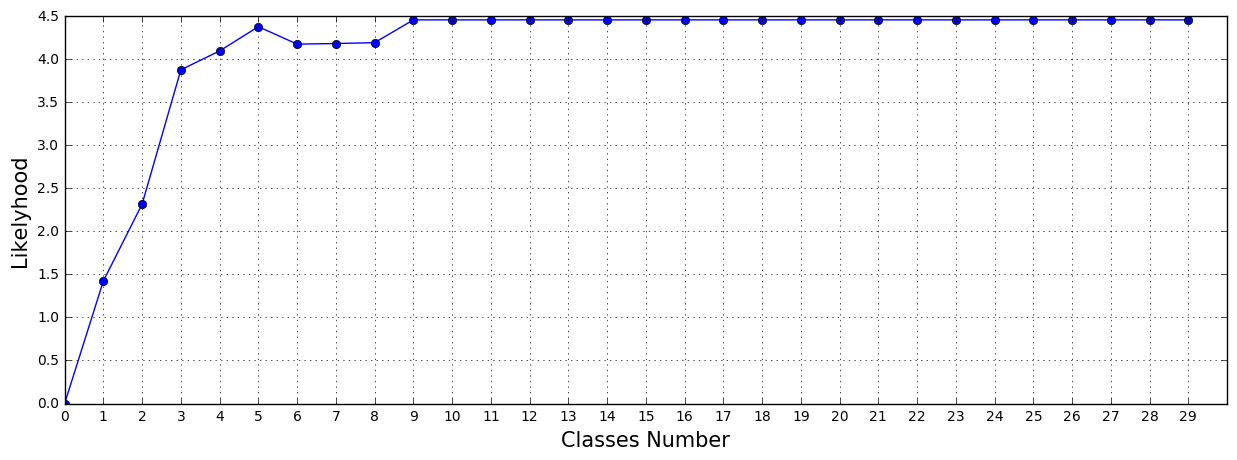

In [103]:
Xk4 = U4 @ np.diag(S4)
GMMchoseK(Xk4)

Categories of 4 cluster by GMM
Cluster 1 size: 53452
Cluster 2 size: 3559
Cluster 3 size: 12244
Cluster 4 size: 14359


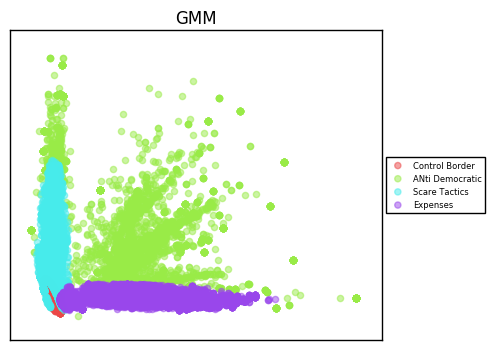

In [105]:
gtag4=GMM(Xk4,df_leave, glabel_l)

In [297]:
gtag_remain = [np.concatenate([gtag1[i], gtag2[i]]) for i in range(len(gtag1))]
gtag_leave = [np.concatenate([gtag3[i], gtag4[i]]) for i in range(len(gtag3))]

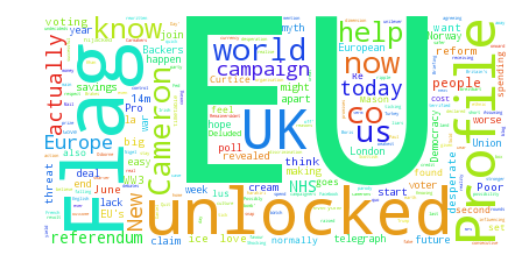

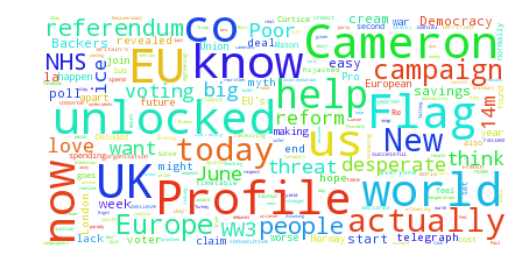

In [146]:
gtexts_remain = ''
for i in gtag_remain:
    temp = ' '.join(i)
    gtexts_remain += temp
word_cloud(gtexts_remain)

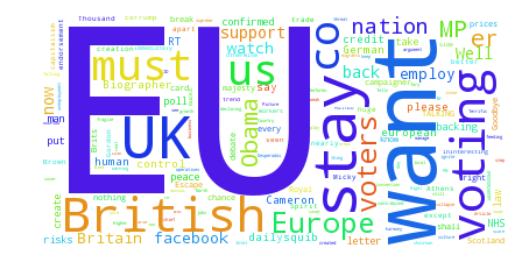

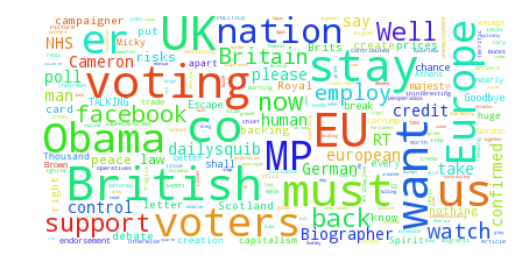

In [149]:
gtexts_leave = ''
for i in gtag_leave:
    temp = ' '.join(i)
    gtexts_leave += temp
word_cloud(gtexts_leave)